In [869]:
# Import libraries:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

from sklearn.decomposition import PCA
from pca import pca

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

In [870]:
# Load data:
df = pd.read_csv('USarrests.csv')
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [871]:
# Renaming 'City' column to 'States' as the column 'City' represents different states:
df = df.rename(columns= {'City': 'State'})

In [872]:
# Checking missing values:
print("The number of missing values per column: ")
df.isnull().sum()


The number of missing values per column: 


State       0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [873]:
# Dropping duplicates and checking data shape:
df.drop_duplicates(keep='first')
df.shape

(50, 5)

In [874]:
# Checking data types
df.dtypes

State        object
Murder      float64
Assault       int64
UrbanPop      int64
Rape        float64
dtype: object

In [875]:
# For convenience transforming int64 type columns to float64:
df['Assault'] = df['Assault'].astype(float)
df['UrbanPop'] = df['UrbanPop'].astype(float)

In [876]:
# Confirming changes:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     float64
 3   UrbanPop  50 non-null     float64
 4   Rape      50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [877]:
# View the statistics for numerical columns: 
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


The dataset contains data on murder, assault and rape made per 100,000 residents as well as percent of the population living in urban areas for 50 states in the US in 1973. There are no missing values. 
The aim of this report is to analyse how data samples cluster together and how each crime type relates to each state using PCA and clustering methods. Column 'Statess - is the dependent or response variable and the other features are independent variables or predictor variables. 

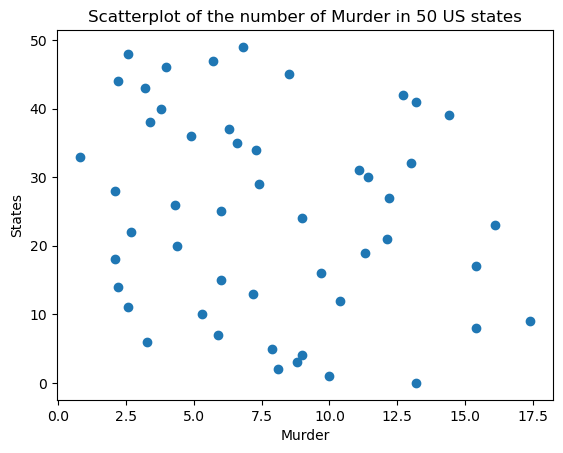

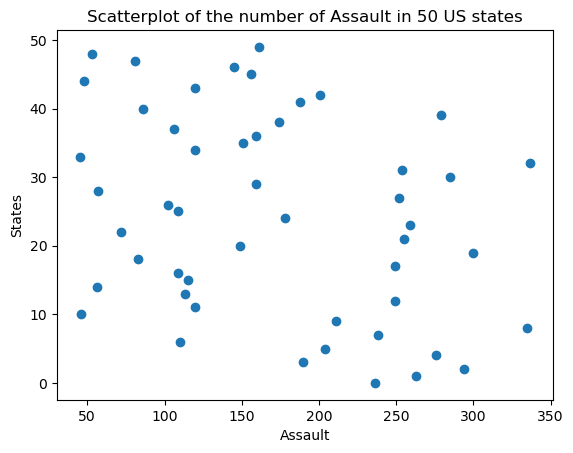

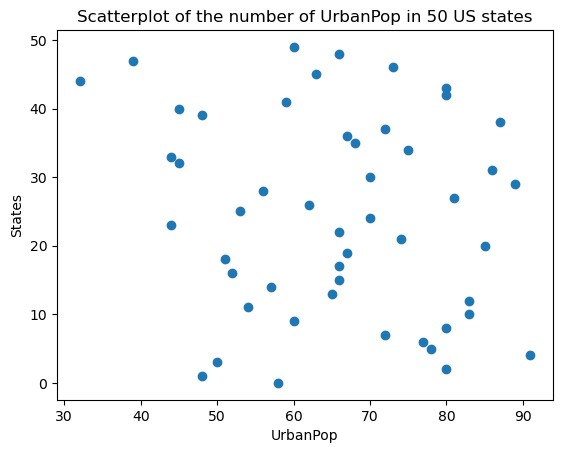

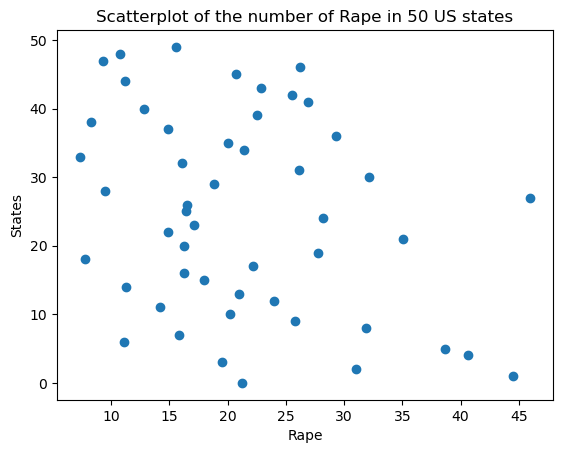

In [878]:
# First I want to see if the data instances for the numerical features associate in any way with the states when analysed feature by feature:
for f in df.columns[1:]:
  plt.scatter(df[f], df.index)
  plt.xlabel(f)
  plt.title(f"Scatterplot of the number of {f} in 50 US states")
  plt.ylabel('States')
  plt.show()

The states in general don't show clusters for any of the numerical features, except maybe assault, where two clusters can be identified. Next, I will look into numerical data distribution and relationships between only numerical features.

<Figure size 500x500 with 0 Axes>

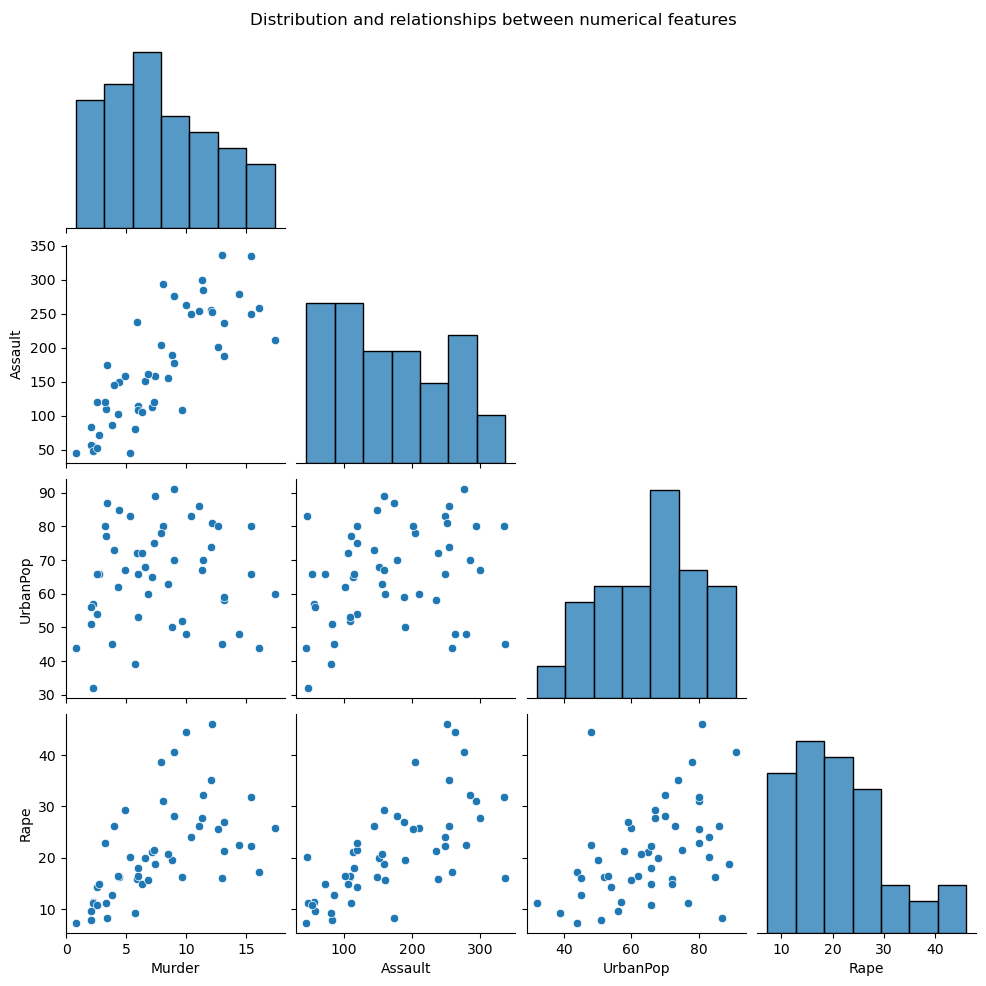

In [879]:
# Checking data distribution and relationship trends by plotting a pairplot displaying scatterplots and histograms for each numerical variable:
plt.figure(figsize = (5,5))
sns.pairplot(df, corner=True)
plt.suptitle("Distribution and relationships between numerical features")
plt.show()

There are possibly weak correlations between: assault and murder, assault and rape and murder and rape. That will be investigated further. Looking at histograms, assault values contain the highest values (range from 0 - 300), on the other hand Murder values are between 0 and 15. These differences will not be useful for PCA, therefore data will need to be scaled. The histograms show shapes close to normal distribution, skewed to the left for rape, assault and murder, suggesting these types of crimes are more common in lower than higher numbers in the US states.  

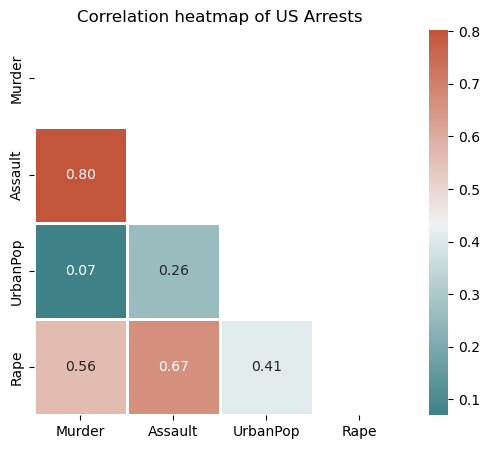

In [880]:
# Checking more closely how different features correlate with one another:
colormap = sns.diverging_palette(200, 20, as_cmap=True) # Select palette for heatmap:
corrs = df.corr() # get correlation coefficients
fig, ax = plt.subplots(figsize=(6, 5)) # plot figsize
dropSelf = np.zeros_like(corrs) # mask data for the same shape and type 
dropSelf[np.triu_indices_from(dropSelf)] = True # mask data in the mirrered side
ax = sns.heatmap(corrs, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=1) # generate heatmap with correlation value to 2 decimal places 
plt.title("Correlation heatmap of US Arrests")
plt.show()

Correlation matrix confirmed earlier prediction about relationships between features. There is a positive correlation for assault vs murder, assault vs rape and murder vs rape. To be able to compare data from different columns, data needs to be scaled. Data in column 'UrbanPop' represents percentage data, whereas other columns are numbers per 100,000 residents. Data will be scaled using StandardScaler, as previously freatures have shown close to normal distribution.

In [881]:
# Scale data to standardize values:
scaled = StandardScaler().fit_transform(df.iloc[:,1:5])

# Create a data frame from scaled data:
df_scaled = pd.DataFrame(scaled, columns = df.columns[1:5])
df_scaled.head()

,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


PCA analysis will now be performed to take our four dimensions of data (four features) and create a 2D PCA plot with it. The analysis will tell us which feature is most valueble for clustering the data. First, a PCA model will be performed and Eigenvectors (components) calculated for each feature. 

In [882]:
# Create a PCA model on scaled data:
pca1 = PCA().fit(df_scaled)
# Calculate and visualise PCAs (Eigenvectors):
print(pd.DataFrame(pca1.components_,columns=df_scaled.columns,index = ['PC-1','PC-2','PC-3','PC-4']))

        Murder   Assault  UrbanPop      Rape
PC-1  0.535899  0.583184  0.278191  0.543432
PC-2  0.418181  0.187986 -0.872806 -0.167319
PC-3 -0.341233 -0.268148 -0.378016  0.817778
PC-4  0.649228 -0.743407  0.133878  0.089024


We can see that PCA1 is highest for Assault, closely followed by Rape and Murder, whereas PC2 is highest for UrbanPop (PCA sign does not affect its interpretation since the sign does not affect the variance). PCA 3 is highest for Rape and PC4 is highest for Assault. Next, it will be determined what is the minimum number of principal components that account for most of the variation. Features with high variance dominate in identifying principal components, as the PCA process is based on finding the vector (direction) that maximises the variance. Therefore it is important to calculate the variance of each of principal components. For PCA analysis we aim for cumulative variance factor between 80 and  99 percent. Minimum cumulative variance should be above 60% for data to be reliable. Sklearn can identify the minimum number of components to reach this variance.  

In [883]:
# Calculate variance for each PCA component:
pca_var = pca1.explained_variance_
# Calculate variance ratio for PCA components:
pca_variance = pca1.explained_variance_ratio_
print("Variance for: PC1, PC2, PC3, PC4 (respectively):", pca_variance)

Variance for: PC1, PC2, PC3, PC4 (respectively): [0.62006039 0.24744129 0.0891408  0.04335752]


To determine the amount of variance that the components explain, the cumulative proportion is used. The variances will be plotted on a graph. For n-number of components, the sum of variances for these components will be plotted. The acceptable levels will be set to 85%, which is ok for descriptive purposes.

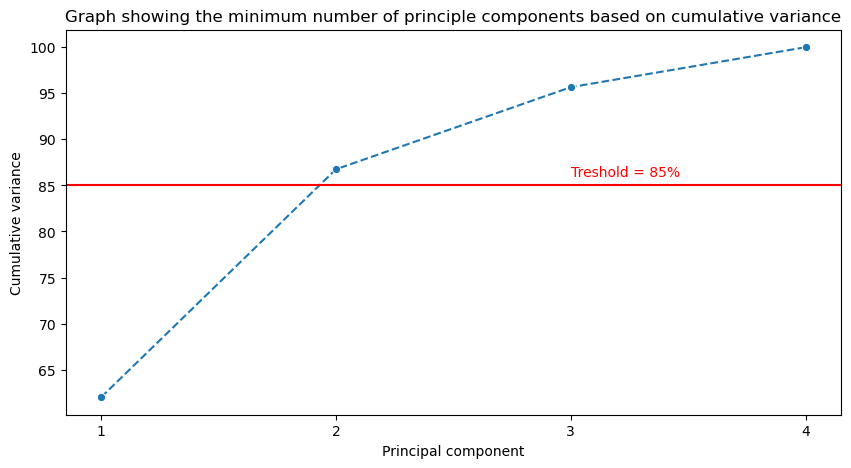

In [884]:
# Plotting the variance values to determine the minimum number of components needed for valid analysis:
# setting up x as the number of principal components:
X= np.arange(1,5,step=1) 
plt.figure(figsize = (10,5))
# plotting x vs y= cumulative variance for features, times 100 to express data in %
sns.lineplot(x=X, y=np.cumsum(pca1.explained_variance_ratio_)*100, linestyle = '--', marker = 'o') 
plt.title("Graph showing the minimum number of principle components based on cumulative variance")
plt.xlabel('Principal component')
plt.xticks(np.arange(1,5,step=1))
plt.ylabel('Cumulative variance')
plt.text(3, 86, 'Treshold = 85%', color = 'red', fontsize = 10)
plt.axhline(y=85, color = 'r')
plt.show()

PC1 and PC2 account for the majority of the variation in the data. That means that minimum number of principal components should be at least 2, because their cumulative variance (62% + 24%) will be above the treshold and will be able to explain 86.7% of variance within our data. 

In [885]:
# Retrain the model with n_components = 2, that explain an acceptable level of variance: 
pca2 = PCA(n_components=2)
# Fit and transform model on the scaled data:
principal_components = pca2.fit_transform(df_scaled)
principal_components.shape

(50, 2)

In [886]:
# Transform PC1 and PC2 values into a data frame: 
principal_components_df = pd.DataFrame(data= principal_components, columns = ['PC 1', 'PC 2'])
# Adding 'State' column to the data frame:
principal_components_df['State'] = df['State']
principal_components_df.head()

,PC 1,PC 2,State
0,0.985566,1.133392,Alabama
1,1.950138,1.073213,Alaska
2,1.763164,-0.745957,Arizona
3,-0.141420,1.119797,Arkansas
4,2.523980,-1.542934,California


In [887]:
# using set_index() to set index 'State' into data frame:
principal_components_df = principal_components_df.set_index('State')
principal_components_df.head()

,PC 1,PC 2
State,,
Alabama,0.985566,1.133392
Alaska,1.950138,1.073213
Arizona,1.763164,-0.745957
Arkansas,-0.141420,1.119797
California,2.523980,-1.542934


PCA values earlier showed that PC1 correlated with murder, assault, rape, whereas PC2 most correlated with Urban population. To confirm and recover the one feature name that mostly contribute to PCA1 and PCA 2, I used the following code adapted from: https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis/50845697#50845697. The analysis confirmed that PCA1 mostly represents Assault and PC2 - UrbanPop.

In [888]:
# Recovering features names of PCA 1 and PCA2. The important features have a large absolute value/score on the component.

# Model the PCA on scaled data:
model_feat = PCA(n_components=2).fit(df_scaled)
# Assign a value for the number of components:
n_pcs= model_feat.components_.shape[0]
# get the index of the most important feature on each component
most_important = [np.abs(model_feat.components_[i]).argmax() for i in range(n_pcs)]
# Provide feature names:
feature_names = ['Murder','Assault','UrbanPop','Rape']
# Get the most important features:
most_important_names = [feature_names[most_important[i]] for i in range(n_pcs)]
# Create a dictionary of names and PCA values: 
pca_dic = {'PC 1': most_important_names[0],'PC 2': most_important_names[1]}
# Convert data into the dataframe:
pca_names_df = pd.DataFrame(pca_dic.items())
pca_names_df.head()

# Adapted from: https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis/50845697#50845697

,0,1
0,PC 1,Assault
1,PC 2,UrbanPop


Next, the variation ratio for PCA 1 and PC 2 will be visualised, by using function that calculates variance ratio for the components. PCA data will be visually presented on a Scree Plot, which is a representation of percentages of variation that each PC accounts for. The scree plot orders the eigenvalues from largest to smallest. 

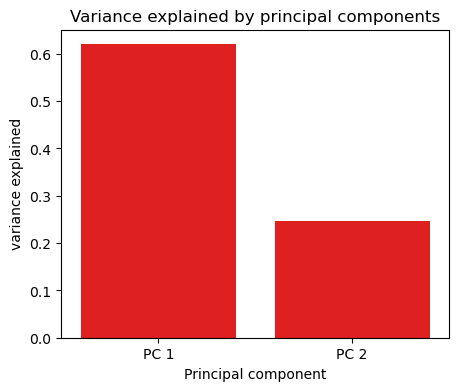

In [889]:
# How each component explains the variance (barplot):
data_frame = pd.DataFrame({'variance explained': pca2.explained_variance_ratio_, 'Principal component': ['PC 1','PC 2']})
plt.figure(figsize = (5,4))
plt.title("Variance explained by principal components")
sns.barplot(x='Principal component', y= 'variance explained', data = data_frame, color = 'r')
plt.show()

Next, a biplot will be created that represents the relationship between the PCs and the original values. It shows how data samples relate to PCs. 

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 with loadings.
[colourmap]> Warning: Colormap [Set1] can not create [50] unique colors! Available unique colors: [9].
[colourmap]> Warning: Colormap [Set1] can not create [50] unique colors! Available unique colors: [9].


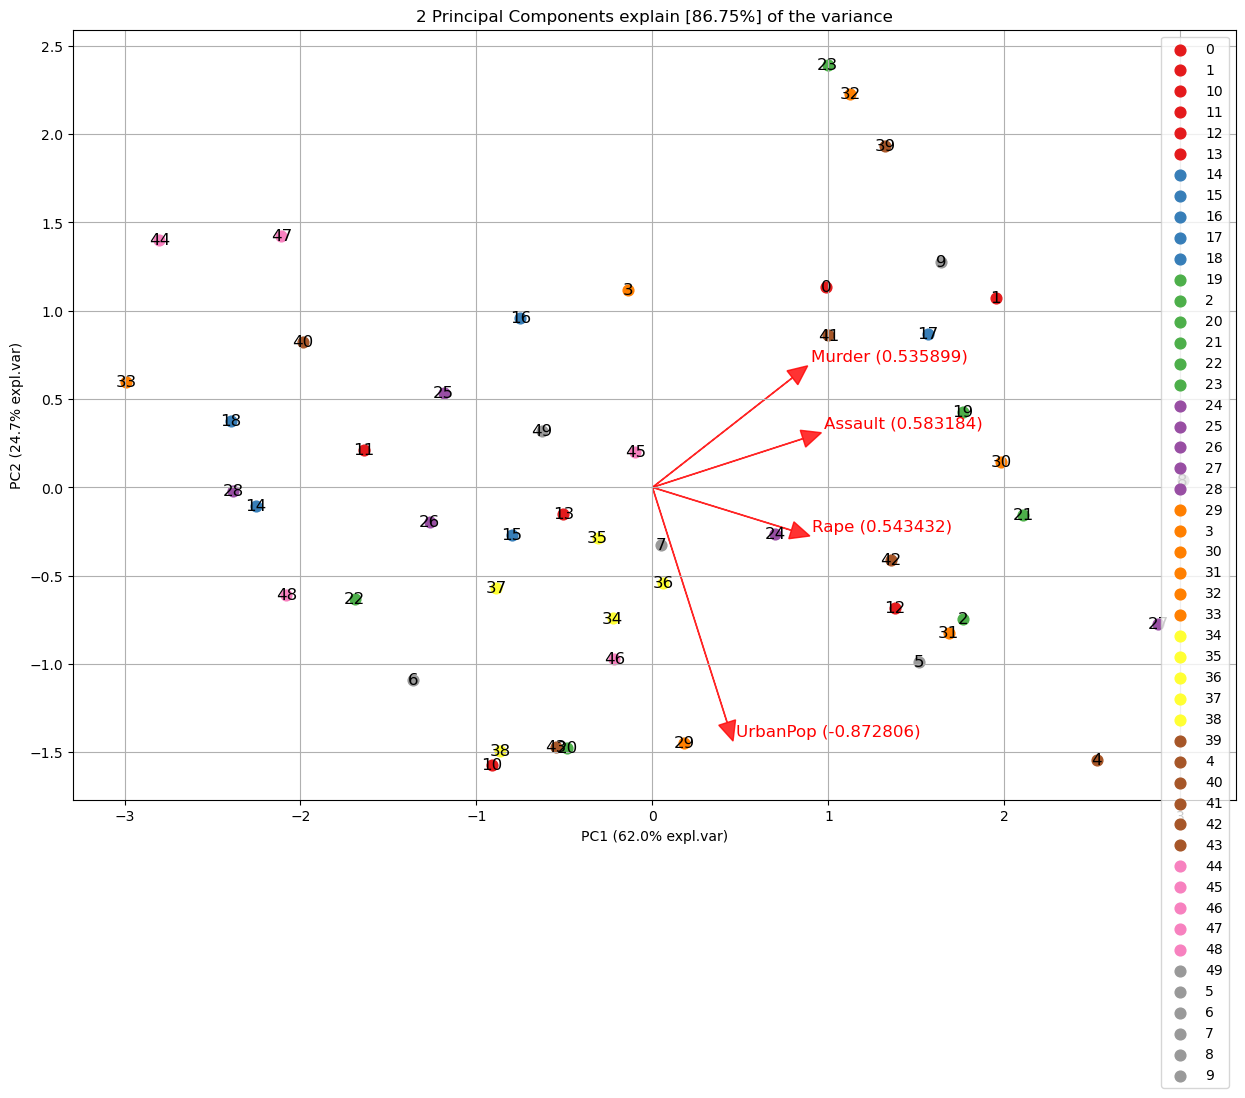

In [890]:
# Create a biplot to represent components within the total Data Frame:
model = pca(n_components = 2)
results = model.fit_transform(df_scaled)
fig, ax = model.biplot(n_feat = 4)
plt.show()

We see that similar states cluster together. The importance of each feature is reflected by the magnitude of the corresponding values in the eigenvectors (higher magnitude - higher importance). We can see that the first principal component has significant positive association with Rape, Assault and Murder. The second principal component has a large negative association with Urban population. 

Eventhough, UrbanPop vector is the longest from the data origin, it is assigned as PC2 (vector perpendicular to primary PC1 vector = Assault), because for PC1 all three Assault, Rape and Murder, cumulatively contribute more to data separation, than for PC2. Below are the eigenvectors and eigenvalues of a covariance (or correlation) calculated before to confirm that:       
        Murder   Assault  UrbanPop      Rape
PC-1  0.535899  0.583184  0.278191  0.543432
PC-2  0.418181  0.187986 -0.872806 -0.167319 
 
Analysing the graph, we can see how states cluster, depending on PC1 (for which the main contributing factor is Assault, but also rape and murder) and PC2 (for which main contribution factor is urban population and assault. For example, we can see that states: 23,32,39 cluster together by having a larger number of assaults, compared to e.g. 28 and 14. Further analysis will reveal which particular states fall into which category. For now, I can say that graph may suggest the presence of two main clusters, one including states that correlate negatively with PC1 and the second smaller cluster of states that correlate positively with PC1. Instances in both of these clusters show both positive and negative correlation with the PC2. Further clustering analysis will shed more light whether it is useful to divide data into 2 or maybe 4 clusters.  

Having done PCA, I will now utilize k-means algorithm, that looks for an ideal number of clusters in our dataset, without accounting for feature types. The algorithm calculates cluster center that is an average of all points that belong to the clusters and position each points to the nearest cluster center, compared with the other clusters and cluster centers. To do k-means clustering, an input of the number of clusters is required, so before I do that I will use an Elbow method for choosing an ideal value for k (clusters). The elbow Kmeans method is run multiple times with increasing values of k, which is plotted against the sum of squared distances of samples to their closest cluster center (called inertia). The value of k to choose is identified from the resulting plot where there is an 'elbow' in the graph (the biggest kink). Hovever, k-means can be ineffective if the clusters have complicated geometries.

In [891]:
# Principal components data will be scaled for k-means analysis:
pc = principal_components_df
pc = preprocessing.scale(pc) 

c:\Users\bdzie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


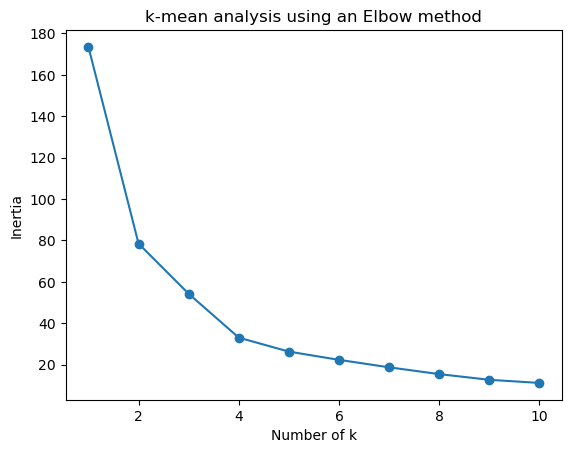

In [892]:
# Evaluate the number of K means, so the number of clusters for the PCA data:
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r)
    kmeans.fit(x)    
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=123):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1,max_k+1)]
    plt.plot(range(1,11), within_cluster_vars,marker='o')
    plt.xlabel('Number of k')
    plt.ylabel('Inertia')
    plt.title("k-mean analysis using an Elbow method")
    plt.show()

elbow_Kmeans(principal_components_df, r=0)

Looking at the graph, the biggest angle is either for K = 2 or K=4. I will analyse clusters with k-means values between 2 and 4 and calculate Silhouette scores for these. This score quantifies how good is the clustering technique and how well apart each cluster is from another, by looking at the distance between clusters and the distance to each point. Its value is between 1 and -1 and the higher value, the better clustering process. 

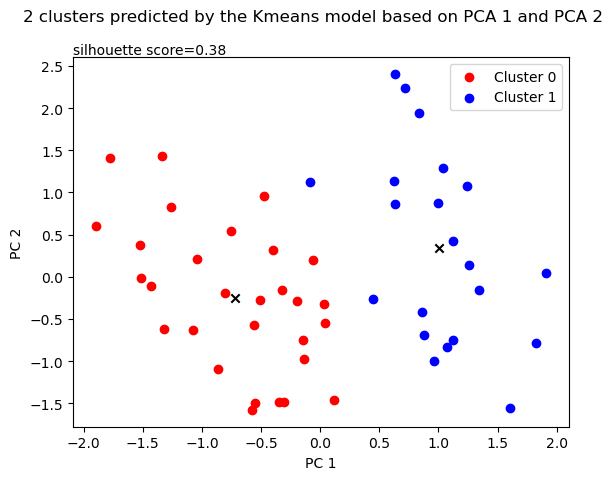

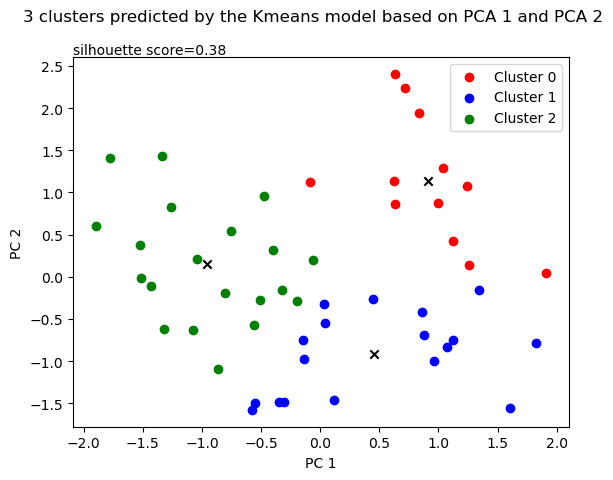

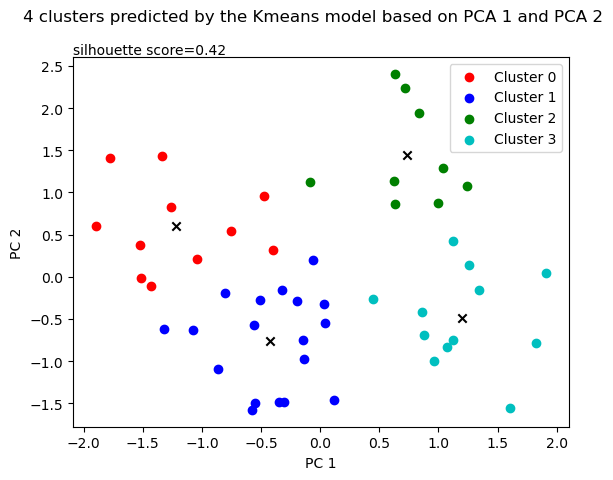

In [893]:
# Visualise n-clusters by the K means model for PCA data:  
def scatter_Kmeans(x, k, r=0):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=r)
    y_pred = kmeans.fit_predict(x)
    colours = 'rbgcmy'
    for c in range(k):
      plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')
    
    score = round(silhouette_score(x, kmeans.labels_, metric='euclidean'),2)
    plt.title('silhouette score={}'.format(score), loc='left', fontdict={'fontsize': 10}, pad=-14)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.suptitle(f'{k} clusters predicted by the Kmeans model based on PCA 1 and PCA 2')
    plt.legend()
    plt.show()

for k in range(2,5):
  scatter_Kmeans(pc, k)

The best silhouette score was actually achieved using k=4, suggesting the data should be clustered into 4 clusters.
Now, I will explore another way to cluster data, using hierarchial clustering (Agglomerative Clustering from sklearn). This method calculates the sum of squares of all possible cluster merges and picks the optimal merge. Linkage criterion is what determines the point from which the distance between clusters is calculated, and so determines dissimilarity measures. There are three main linkage types: simple, complete and average. All measure dissimilarity by calculating distance bewteen all samples in one cluster to all samples in another cluster. The simple linkage applies the smallest dissimilarity between samples, complete - largest, and average - average. I will analyse the three types of linkages on our data, using euclidean distance metric (one of the most commonly used distance metrics) and number of clusters = 4.

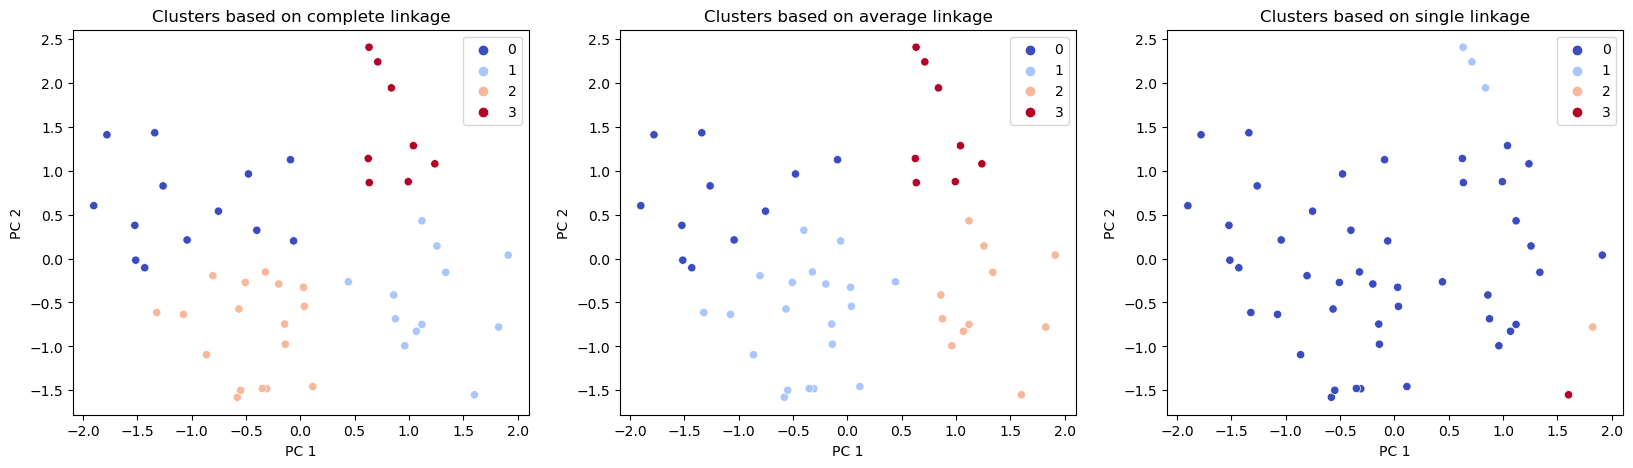

In [894]:
# Analyse which linkage type will be the best for our data:
plt.figure(figsize=(20,5))

linkage_types = ['complete', 'average', 'single']
cmap="coolwarm"

for i, l in enumerate(linkage_types):
  plt.subplot(1, 3, i+1)
  cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage=l)
  cluster.fit_predict(pc)
  ax = sns.scatterplot( x=pc[:,0], y=pc[:,1], hue=cluster.labels_, palette=cmap)
  plt.title('Clusters based on {} linkage'.format(l))
  plt.xlabel('PC 1')
  plt.ylabel('PC 2')

Clearly using complete and average linkage provided with more balanced clustering than single linkage. Looking at the previously shown biplot, we can see that between clusters based on complete linkage and clusters based on average linkage, only three states were differently classified: 24, 45 and 49, respectively: Missouri, Virginia, Wyoming. 
Complete linkage model classified Virginia and Wyoming to cluster 0 in the upper left, and Missouri to cluster 1 = bottom right cluster.
Average linkage model classified all these three states to cluster 1 = bottom left cluster.

In [895]:
# create a dictionary of index and state names for sample identification purpose:
# convert index and state names to lists:
index_list= list(df.index)
state_list= list(df.State)
# create a dictionary of index vs state name:
index_state_dict = {}
for key in index_list:
    for value in state_list:
        index_state_dict[key] = value
        state_list.remove(value)
        break
print(index_state_dict)

{0: 'Alabama', 1: 'Alaska', 2: 'Arizona', 3: 'Arkansas', 4: 'California', 5: 'Colorado', 6: 'Connecticut', 7: 'Delaware', 8: 'Florida', 9: 'Georgia', 10: 'Hawaii', 11: 'Idaho', 12: 'Illinois', 13: 'Indiana', 14: 'Iowa', 15: 'Kansas', 16: 'Kentucky', 17: 'Louisiana', 18: 'Maine', 19: 'Maryland', 20: 'Massachusetts', 21: 'Michigan', 22: 'Minnesota', 23: 'Mississippi', 24: 'Missouri', 25: 'Montana', 26: 'Nebraska', 27: 'Nevada', 28: 'New Hampshire', 29: 'New Jersey', 30: 'New Mexico', 31: 'New York', 32: 'North Carolina', 33: 'North Dakota', 34: 'Ohio', 35: 'Oklahoma', 36: 'Oregon', 37: 'Pennsylvania', 38: 'Rhode Island', 39: 'South Carolina', 40: 'South Dakota', 41: 'Tennessee', 42: 'Texas', 43: 'Utah', 44: 'Vermont', 45: 'Virginia', 46: 'Washington', 47: 'West Virginia', 48: 'Wisconsin', 49: 'Wyoming'}


Complete and average linkage types look the best in separating values into 4 clusters. To have another view of the hierarchial clustering I will visualise data points using dendrograms, but this time only for complete and average linkage types. The vertical height of lines corresponds to the euclidean distance between clusters, and may help to choose the desired linkage. 

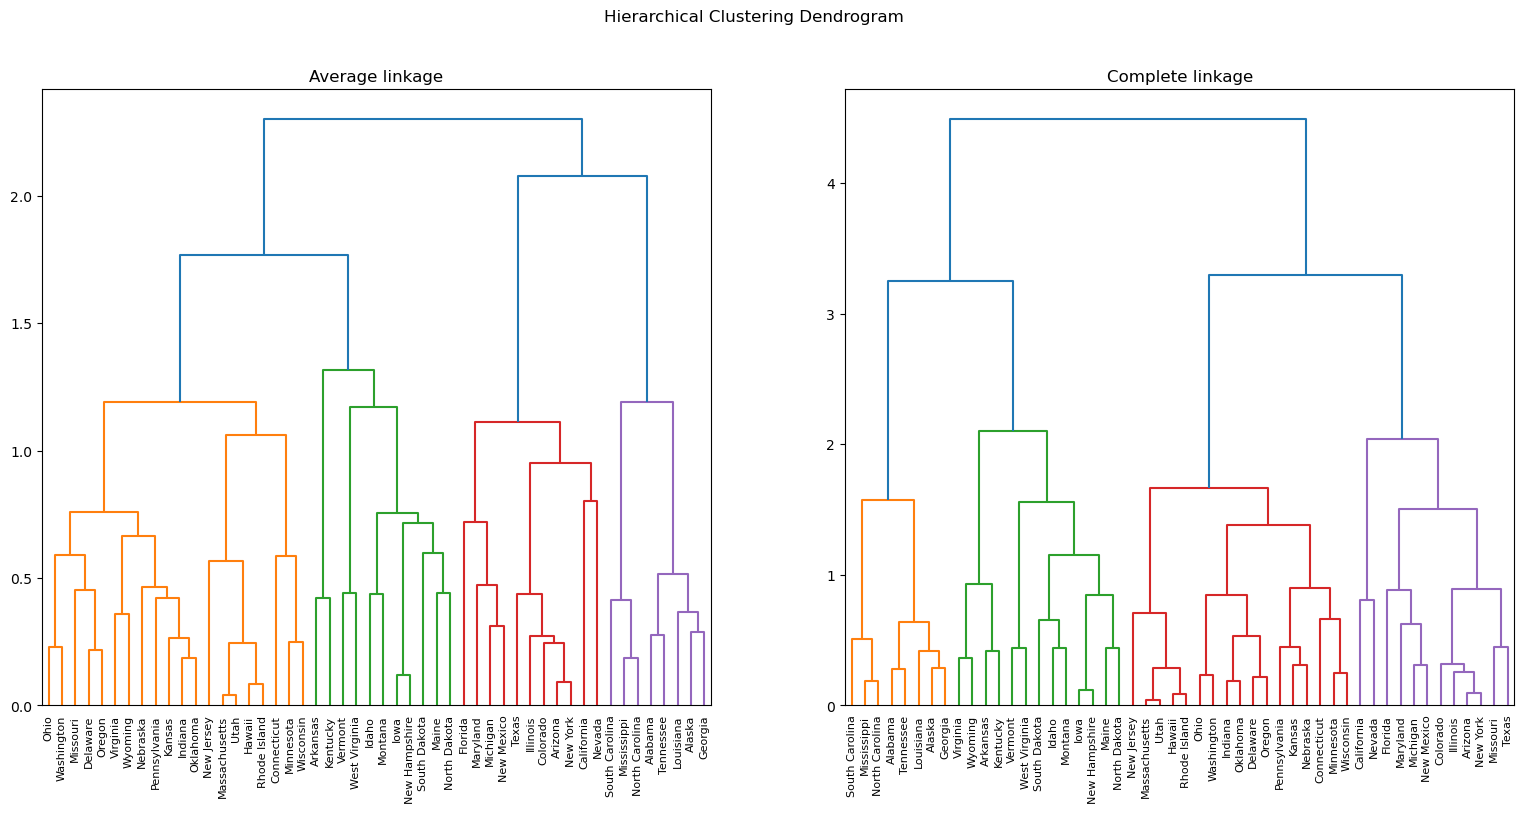

In [896]:
# Visualising dendrograms for two linkage types: average and complete:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(19, 8)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Average linkage")
dendrogram(linkage(pc, method='average'), labels=principal_components_df.index, ax=ax1)
ax2.set_title("Complete linkage")
dendrogram(linkage(pc, method='complete'), labels=principal_components_df.index, ax=ax2)
plt.show()

Similarly to Agglomerative clustering, dendrogram based on average linkage classified Virginia, Wyoming and Missouri to a single cluster, whereas dendrogram based on complete linkage classified Virginia and Missouri into one cluster and Wyoming separately to another cluster. In both cases, data was clustered into four groups. The dendrogram based on complete linkage seems to produce more balanced clusters, and therefore of all the options, I will use the following parameters for my final clustering process: euclidean distance, complete linkage, number of clusters = 4. Using visual criteria, if we cut the dendrogram horizontally at y = 3, we will get the four clusters. This will be again visualised by a dendrogram and a scatterplot and the names of states will be revealed for each cluster.

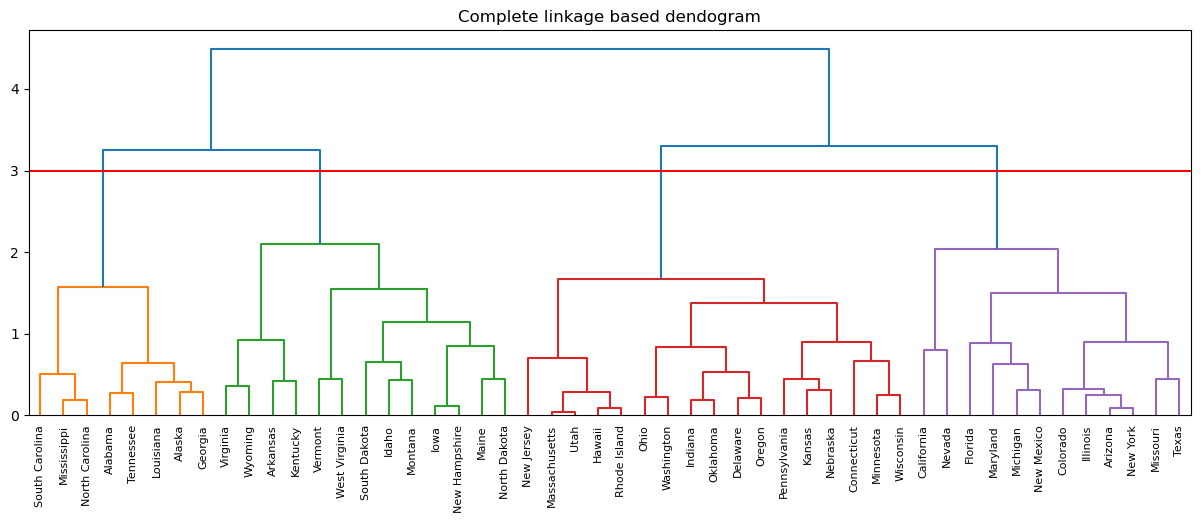

In [897]:
# Visualise the final dendrogram with the chosen parameters:
plt.figure(figsize = (15,5))
dend = dendrogram(linkage(pc, method='complete'), labels=principal_components_df.index)
plt.title("Complete linkage based dendogram")  

# Cutting dendrogram at y = 3
# cut = cut-off/ Threshold value
cut = 3
plt.axhline(y=cut, c='r')

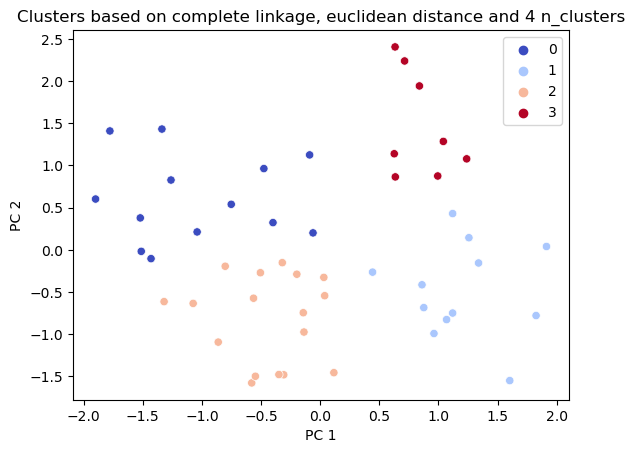

In [898]:
# Visualise the final scatterplot with the chosen parameters:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage= 'complete')
cluster.fit_predict(pc)
cmap = 'coolwarm'
sns.scatterplot( x=pc[:,0], y=pc[:,1], hue=cluster.labels_, palette=cmap)
plt.title('Clusters based on complete linkage, euclidean distance and 4 n_clusters')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [899]:
# Get the names of states in each cluster:
# train the model:
cluster_labels = cluster.fit_predict(pc)
# get indices for the clusters:
c_0_indices = np.argwhere(cluster_labels==0).transpose()[0]
c_1_indices = np.argwhere(cluster_labels==1).transpose()[0]
c_2_indices = np.argwhere(cluster_labels==2).transpose()[0]
c_3_indices = np.argwhere(cluster_labels==3).transpose()[0]
# get the state names for each cluster:
c_0 = np.array(principal_components_df.index)[c_0_indices]
c_1 = np.array(principal_components_df.index)[c_1_indices]
c_2 = np.array(principal_components_df.index)[c_2_indices]
c_3 = np.array(principal_components_df.index)[c_3_indices]

print(f"States in cluster 0: {c_0}")
print(f"States in cluster 1: {c_1}")
print(f"States in cluster 2: {c_2}")
print(f"States in cluster 3: {c_3}")

States in cluster 0: ['Arkansas' 'Idaho' 'Iowa' 'Kentucky' 'Maine' 'Montana' 'New Hampshire'
 'North Dakota' 'South Dakota' 'Vermont' 'Virginia' 'West Virginia'
 'Wyoming']
States in cluster 1: ['Arizona' 'California' 'Colorado' 'Florida' 'Illinois' 'Maryland'
 'Michigan' 'Missouri' 'Nevada' 'New Mexico' 'New York' 'Texas']
States in cluster 2: ['Connecticut' 'Delaware' 'Hawaii' 'Indiana' 'Kansas' 'Massachusetts'
 'Minnesota' 'Nebraska' 'New Jersey' 'Ohio' 'Oklahoma' 'Oregon'
 'Pennsylvania' 'Rhode Island' 'Utah' 'Washington' 'Wisconsin']
States in cluster 3: ['Alabama' 'Alaska' 'Georgia' 'Louisiana' 'Mississippi' 'North Carolina'
 'South Carolina' 'Tennessee']


To conclude we can say that the states separate into four groups:
Cluster 0 - Upper left clasters group of states, which show negative correlation with PCA1 and positive correlation with PCA2
Cluster 2 - Bottom left clasters group of states, which show negative correlation with PCA1 and negative correlation with PCA2
Cluster 3 - Upper right clasters group of states, which show positive correlation with PCA1 and positive correlation with PCA2
Cluster 1 - Bottom right clasters group of states, which show positive correlation with PCA1 and negative correlation with PCA2

Recollecting the directions of Egeinvectors for the four features from the biplot, we can say that in general: 
- states in cluster 2 and 1 tend to have lower urban population, compared with states in clusters 0 and 3.
- states in cluster 0 and 2 tend to have lower rates of murder, rape and assault, compared with states in clusters 1 and 3.

States in cluster 0: 'Arkansas' 'Idaho' 'Iowa' 'Kentucky' 'Maine' 'Montana' 'New Hampshire' 'North Dakota' 'South Dakota' 'Vermont' 'Virginia' 'West Virginia' 'Wyoming'
States in cluster 1: 'Arizona' 'California' 'Colorado' 'Florida' 'Illinois' 'Maryland' 'Michigan' 'Missouri' 'Nevada' 'New Mexico' 'New York' 'Texas'
States in cluster 2: 'Connecticut' 'Delaware' 'Hawaii' 'Indiana' 'Kansas' 'Massachusetts' 'Minnesota' 'Nebraska' 'New Jersey' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'Utah' 'Washington' 'Wisconsin'
States in cluster 3: 'Alabama' 'Alaska' 'Georgia' 'Louisiana' 'Mississippi' 'North Carolina' 'South Carolina' 'Tennessee'
